In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sns.set_theme(style='whitegrid', font_scale=1.3, palette='muted')

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 16

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_size [MB]'] = df['model_size']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)         # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar

def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None):
    ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):
    
    cols_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision', 'training_time', 'eval_time', 'model_size']
    
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(constrained_layout=False, figsize=(12, 8))
    gs = fig.add_gridspec(2, 3)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.1)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    ax1.legend(title='Model', bbox_to_anchor=(1.02, 0.5), loc=2, borderaxespad=0.)
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, 0])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 1])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[1, 2])   
    plot_varaible(df, y='model_size [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [MB]', title = 'Model size', ax=ax4)
    
    fig.suptitle(suptitle)
    fig.tight_layout()
    
def print_model_comparison(df: pd.DataFrame, original_model: str, distilled_model: str):
    results = defaultdict(dict)
    
    for model in [original_model, distilled_model]:
        for col in df.columns:
            value = df[df['model_name']==model][col].values[0]
            results[model][col] = value
            
#     title = f"Comparison between:\n - teacher: {original_model.upper()}\n - student: {distilled_model.upper()}\n"
#     indent = 4 * " "
#     print("#"*(len(title) + 2*len(indent)) )
#     print(title)
    
#     training_time_gain = results[original_model]['training_time_in_minutes'] / results[distilled_model]['training_time_in_minutes']
#     print(f"Training time speedup: {training_time_gain:.1f}x faster")
    
#     eval_time_gain = results[original_model]['eval_time'] / results[distilled_model]['eval_time']
#     print(f"Eval time speedup: {eval_time_gain:.1f}x faster")
    
#     size_gain = results[original_model]['model_size'] / results[distilled_model]['model_size']
#     print(f"Model size reduction: {size_gain:.1f}x smaller")
    
#     quality_retain = results[distilled_model]['macro avg_f1-score'] / results[original_model]['macro avg_f1-score']
#     print(f"Quality: {100*quality_retain:.1f}% of teacher's performance")
#     print("#"*(len(title) + 2*len(indent)) )

    title_1 = "Comparison between:"
    title_2 = f"\n - teacher: {original_model.upper()}\n - student: {distilled_model.upper()}\n"
    seperator = "#"*(int(3*len(title_1)))
    
    text = seperator + "\n" + title_1 + title_2
    
    training_time_gain = results[original_model]['training_time_in_minutes'] / results[distilled_model]['training_time_in_minutes']
    text += f"\nTraining time speedup: {training_time_gain:.1f}x faster"
    
    eval_time_gain = results[original_model]['eval_time'] / results[distilled_model]['eval_time']
    text += f"\nEval time speedup: {eval_time_gain:.1f}x faster"
    
    size_gain = results[original_model]['model_size'] / results[distilled_model]['model_size']
    text += f"\nModel size reduction: {size_gain:.1f}x smaller"
    
    quality_retain = results[distilled_model]['macro avg_f1-score'] / results[original_model]['macro avg_f1-score']
    text += f"\nQuality: {100*quality_retain:.1f}% of teacher's performance"
    text += "\n" + seperator 
    
    fig, ax = plt.subplots()
    ax.set_axis_off()    
    ax.text(0.25, 1, text, bbox={'facecolor':'w','pad': 5}, ha="left", va="top", transform=ax.transAxes, fontsize=16)

# Multiemo EN - All sentences

In [3]:
file_name = 'results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision', 'training_time', 'eval_time', 'model_size [MB]']
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [MB]
0,multiemo_en_all_sentence,distilbert-base-uncased,0.779286,0.741776,0.740405,0.743439,2566.470919,24.098655,255.457139
1,multiemo_en_all_sentence,bert-base-multilingual-cased,0.764143,0.721772,0.717098,0.728474,5324.377136,54.352554,678.548993
2,multiemo_en_all_sentence,bert-base-uncased,0.791471,0.750271,0.742138,0.763748,5030.124383,49.763504,417.733563
3,multiemo_en_all_sentence,distilroberta-base,0.790775,0.747665,0.736346,0.769523,2562.716114,23.862186,313.312604
4,multiemo_en_all_sentence,roberta-base,0.805048,0.768090,0.763399,0.774837,5007.766991,46.833942,475.578534
5,multiemo_en_all_sentence,distilbert-base-multilingual-cased,0.761010,0.722560,0.717686,0.728861,2733.752610,26.378126,516.272569


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      6 non-null      object 
 1   model_name                6 non-null      object 
 2   task_name                 6 non-null      object 
 3   epochs                    6 non-null      int64  
 4   batch_size                6 non-null      int64  
 5   learning_rate             6 non-null      float64
 6   weight_decay              6 non-null      float64
 7   warmup_steps              6 non-null      int64  
 8   max_seq_length            6 non-null      int64  
 9   training_time             6 non-null      float64
 10  accuracy                  6 non-null      float64
 11  eval_time                 6 non-null      float64
 12  z_amb_precision           6 non-null      float64
 13  z_amb_recall              6 non-null      float64
 14  z_amb_f1-score

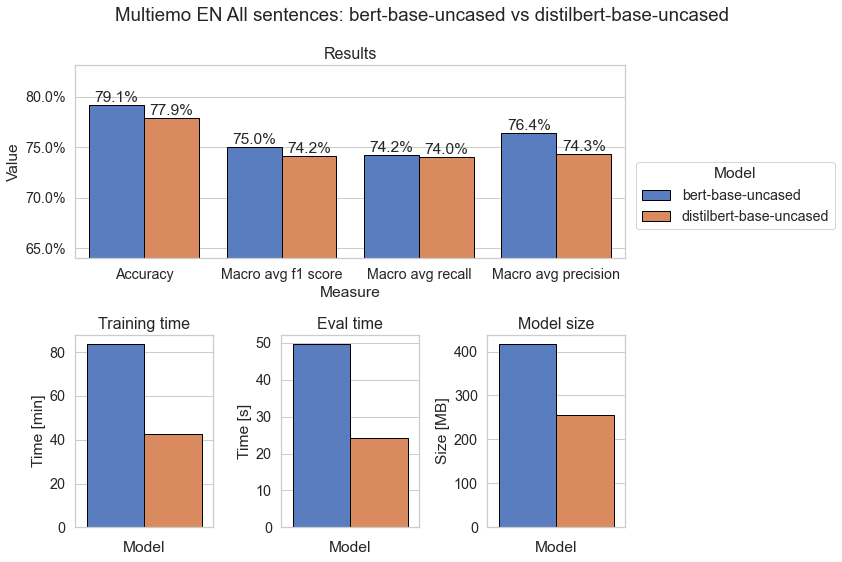

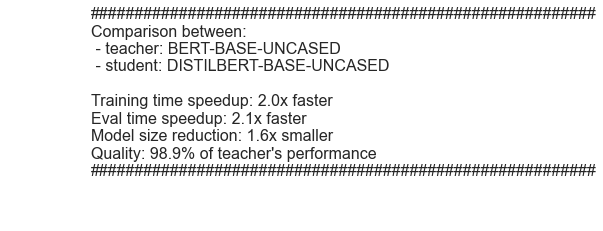

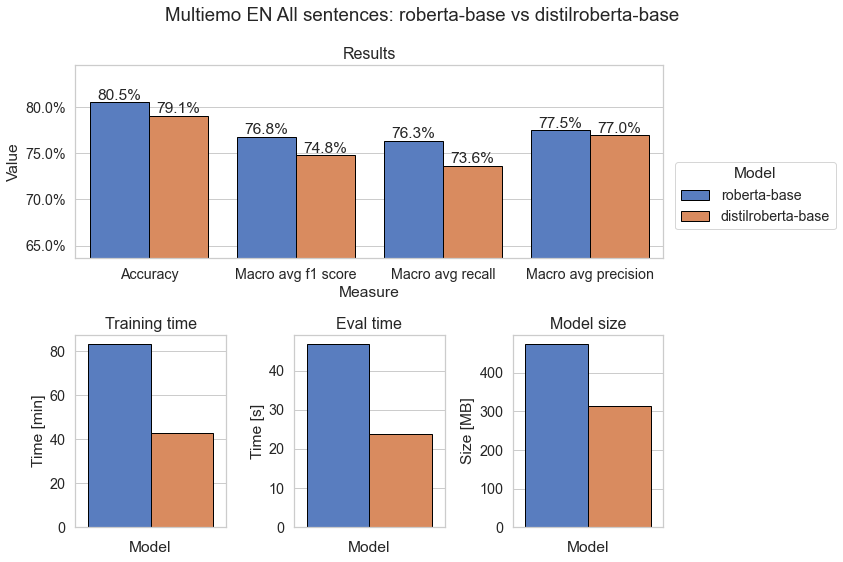

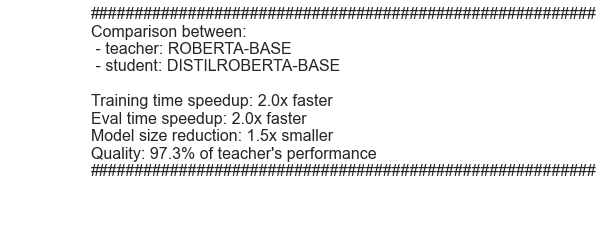

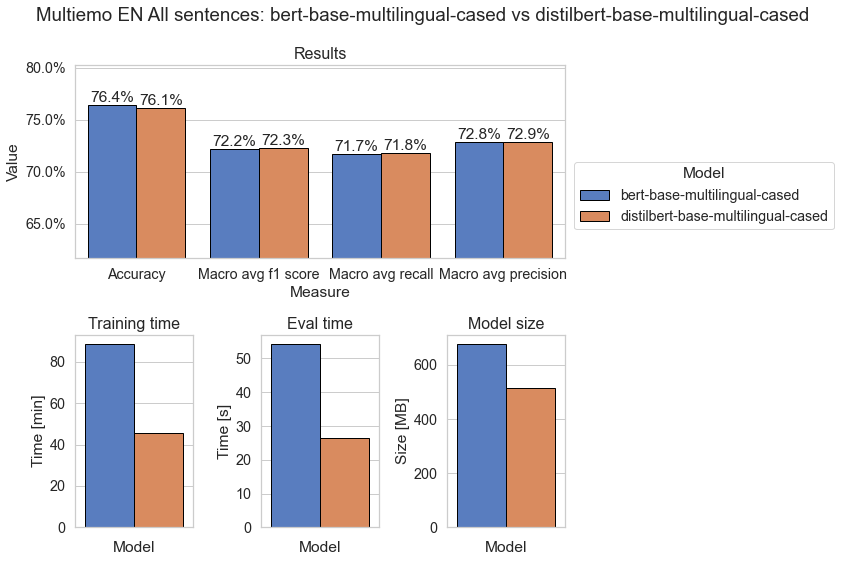

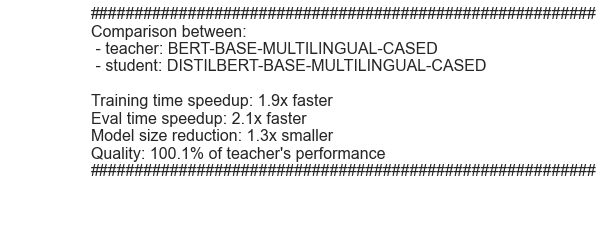

In [5]:
model_pairs = [['bert-base-uncased', 'distilbert-base-uncased'],
               ['roberta-base', 'distilroberta-base'],
               ['bert-base-multilingual-cased', 'distilbert-base-multilingual-cased']]

for models in model_pairs:
    visualize_models(df, models, suptitle='Multiemo EN All sentences: ' + ' vs '.join(models))
    print_model_comparison(df, models[0], models[1])

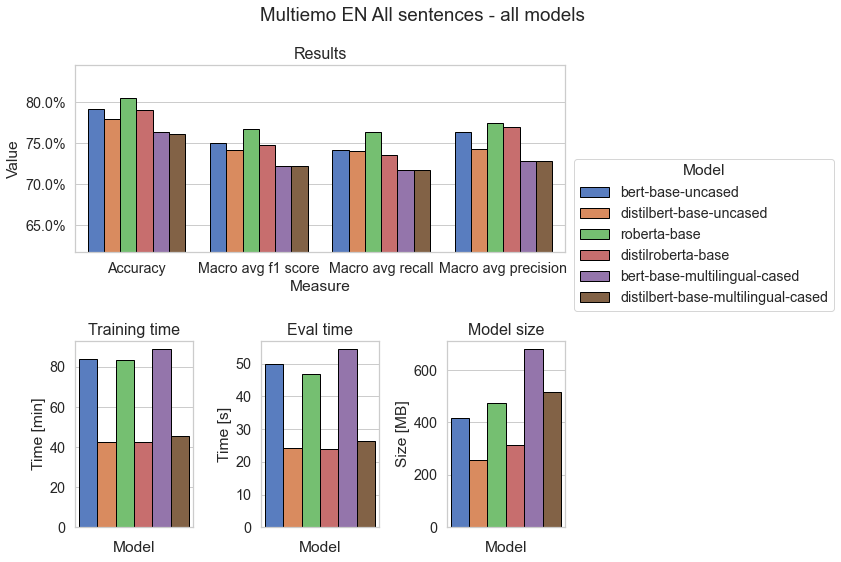

In [6]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'roberta-base', 'distilroberta-base',
          'bert-base-multilingual-cased', 'distilbert-base-multilingual-cased']
visualize_models(df, models, suptitle='Multiemo EN All sentences - all models')

# Multiemo PL - All sentences

In [7]:
file_name = 'results-multiemo_pl_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df = load_results_df(file_path)

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision', 'training_time', 'eval_time', 'model_size [MB]']
df[cols_to_display]

,task_name,model_name,accuracy,macro avg_f1-score,macro avg_recall,macro avg_precision,training_time,eval_time,model_size [MB]
0,multiemo_pl_all_sentence,bert-base-multilingual-cased,0.746562,0.704151,0.697358,0.716215,6320.268218,69.591829,678.548993
1,multiemo_pl_all_sentence,distilbert-base-multilingual-cased,0.748651,0.702641,0.686416,0.740210,2879.252849,31.055493,516.272569


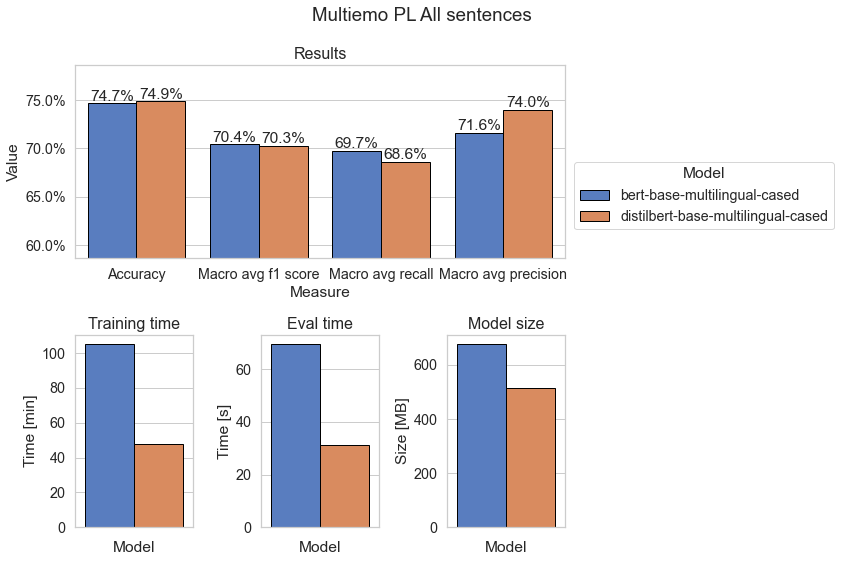

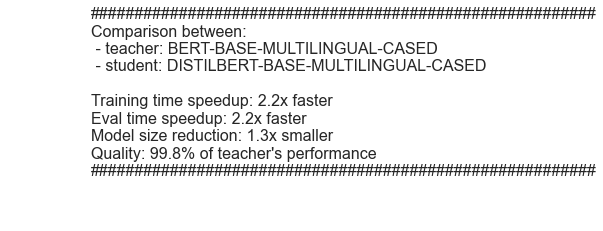

In [9]:
models = ['bert-base-multilingual-cased', 'distilbert-base-multilingual-cased']
visualize_models(df, models, suptitle='Multiemo PL All sentences')
print_model_comparison(df, models[0], models[1])